# SPARC-4 mini-pipeline tools
## Photometry time series

This notebook shows an example for obtaining a photometric time series

* Eder Martioli, LNA 17 May 2023

In [1]:
import os,sys
path_parent = os.path.dirname(os.getcwd())
# path_parent = "/Volumes/Samsung_T5/sparc4-pipeline/"
sys.path.append(path_parent) 
import glob

import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib
import sparc4_utils as s4utils
import sparc4_params

/Users/eder/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Set up work directories and print night log

In [2]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "CR1"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 3  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = sparc4_params.init_s4_p(datadir=DATADIR,
                            reducedir=REDUCEDDIR,
                            nightdir=NIGHTDIR,
                            channels="{}".format(CHANNEL),
                            print_report=False)

### User inputs

In [3]:
# Select a short list of apertures to include in the light curve product
catalog_names = [p['PHOT_REF_CATALOG_NAME']]
# Uncomment below to include all apertures from 2 to 50 pixels - it takes a long time to conclude
#catalog_names = []

### Run the main function to produce a photometric time series product

In [5]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}".format(NIGHTDIR,CHANNEL,OBJECTID)

# input raw files list
raw_sci_list = p['objsInPhotdata'][CHANNEL-1][OBJECTID.replace(" ","")]

# get reduce dir
reduce_dir = p['reduce_directories'][CHANNEL-1]

# input reduced files list
sci_list = ["{}/{}".format(reduce_dir,os.path.basename(f).replace(".fits","_proc.fits")) for f in raw_sci_list]

# run photometric time series
phot_ts_product = s4pipelib.phot_time_series(sci_list, 
                                             ts_suffix=ts_suffix, 
                                             reduce_dir=reduce_dir, 
                                             time_key=p['TIME_KEYWORD_IN_PROC'],
                                             time_format=p['TIME_FORMAT_IN_PROC'], 
                                             ref_catalog_name=p['PHOT_REF_CATALOG_NAME'],
                                             catalog_names=catalog_names, 
                                             force=FORCE)

Packing time series data for catalog: CATALOG_PHOT_AP010


### Plot products

/Users/eder/anaconda3/lib/python3.7/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


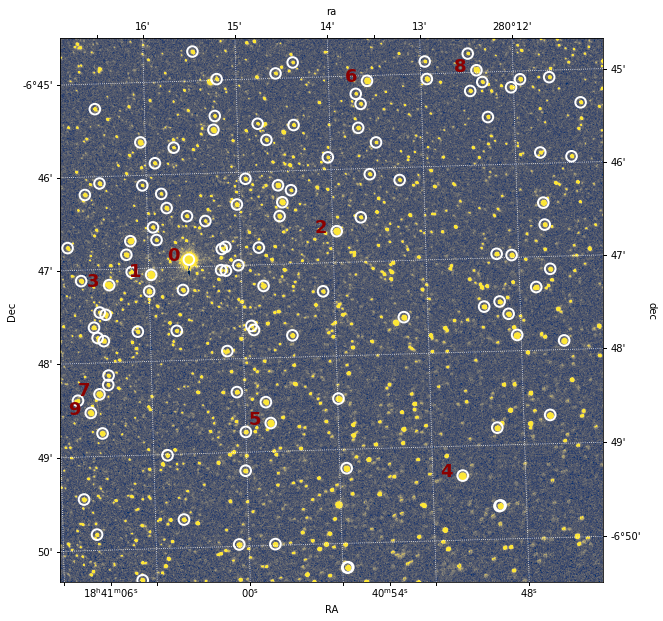

In [8]:
# Plot a science image product to select the target and comparisons
s4plt.plot_sci_frame(sci_list[0], nstars=10, use_sky_coords=True)

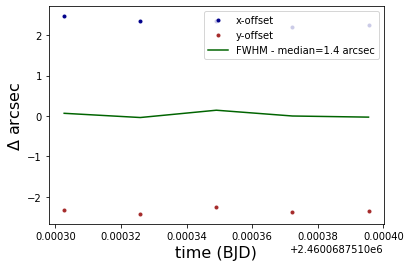

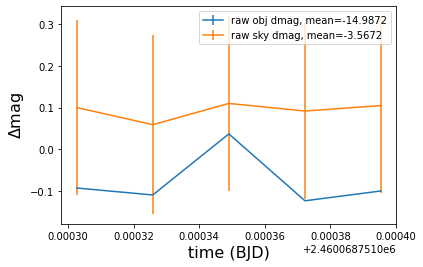

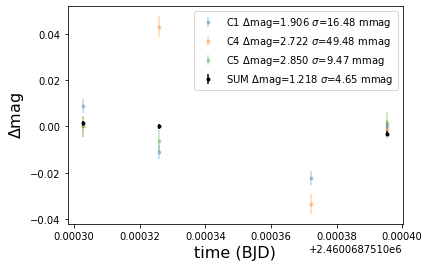

In [9]:
# set target index
target = 0
# set indices for comparison stars
comps = [1,4,5]

# plot time series data
s4plt.plot_light_curve(phot_ts_product, 
                       target=target, 
                       comps=comps, 
                       nsig=3, 
                       plot_coords=True, 
                       plot_rawmags=True, 
                       plot_sum=True, 
                       plot_comps=True, 
                       catalog_name=p['PHOT_REF_CATALOG_NAME'])